# Random Forest Regressor for Kaggle New York City Taxi Fare Prediction [competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import forest

import matplotlib.pyplot as plt
import seaborn as sns

import IPython
from IPython.display import display
import graphviz

from datetime import datetime
import math
import re

import os

/Users/LARCUSER/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Data

## Initial data inspection

In [4]:
df_raw.shape # this gives us about half a million rows, plent for quick prototyping
df_raw.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3
1,2013-01-05 21:36:00.000000198,5.5,2013-01-05 21:36:00 UTC,-73.989692,40.735497,-73.982012,40.739392,1
2,2015-04-18 08:29:08.0000002,11.5,2015-04-18 08:29:08 UTC,-73.955116,40.768990,-73.984238,40.748440,1
3,2009-09-02 05:18:10.0000001,25.7,2009-09-02 05:18:10 UTC,-73.991729,40.760501,-73.861246,40.767619,1
4,2012-11-30 11:02:00.000000111,38.8,2012-11-30 11:02:00 UTC,-73.974620,40.756922,-73.864002,40.767872,1


We immidiately see few problems with the data that need to be addressed:
1. The minimum fare_amount is -60. We expect it to be a positive number.
2. Our latitudes and longitudes for both pickupp and dropoff have some obviously non-sensical values at the extremes.
3. I'm reasonably certain a cab can't hold 218 passengers. Let's set a limit of 10.

## Data Cleanining

In [6]:
print(f'Old size: {len(df_raw)}')

min_fare = 0
max_pass = 10
lat_range = [30, 50]
lon_range = [-85, -65]

df_raw = df_raw[(df_raw.pickup_latitude > lat_range[0]) & 
                (df_raw.pickup_latitude < lat_range[1]) & 
                (df_raw.pickup_longitude > lon_range[0]) & 
                (df_raw.pickup_longitude < lon_range[1]) &
                (df_raw.dropoff_latitude > lat_range[0]) & 
                (df_raw.dropoff_latitude < lat_range[1]) & 
                (df_raw.dropoff_longitude > lon_range[0]) & 
                (df_raw.dropoff_longitude < lon_range[1]) & 
                (df_raw.fare_amount > min_fare) & 
                (df_raw.passenger_count < max_pass)]
print(f'New size: {len(df_raw)}')

df_raw.describe()

Old size: 554238
New size: 542624


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,542624.000000,542624.000000,542624.000000,542624.000000,542624.000000,542624.000000
mean,11.334894,-73.975195,40.750989,-73.974358,40.751282,1.684459
std,9.648467,0.047688,0.040032,0.045290,0.041068,1.307485
min,0.010000,-84.489890,33.844160,-84.489872,33.844167,0.000000
25%,6.000000,-73.992249,40.736586,-73.991585,40.735605,1.000000
50%,8.500000,-73.982072,40.753368,-73.980614,40.753912,1.000000
75%,12.500000,-73.968277,40.767570,-73.965377,40.768416,2.000000
max,315.000000,-65.396312,49.466667,-65.396312,48.416667,6.000000


# 2. Feature Engineering

## Distance feature engineering

/Users/LARCUSER/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Taxi Ride Distance Distribution')

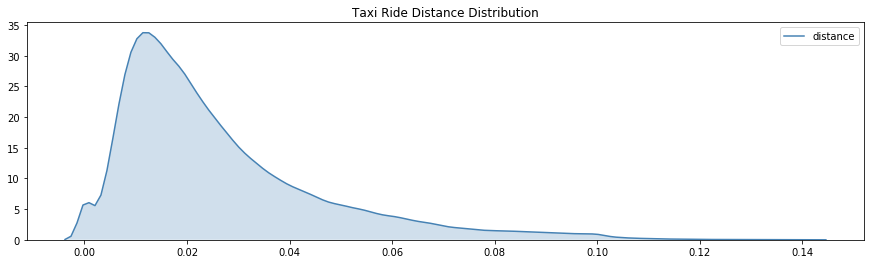

In [7]:
# create two new features representing the latitude and longitude vectors traversed during the trip
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(df_raw)

def add_distance_feature(df):
    df['distance'] = np.sqrt(df.abs_diff_longitude**2 + df.abs_diff_latitude**2)
    
add_distance_feature(df_raw)

short_rides = df_raw[(df_raw['abs_diff_latitude'] < 0.1) & (df_raw['abs_diff_longitude'] < 0.1)]

# Kernel Density Plot for distance travelled 
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(short_rides.distance , color='steelblue',shade=True,label='distance')
plt.title('Taxi Ride Distance Distribution')

The distance travelled follows a positive skewed normal distribution, with the max frequency at less than 0.02 degrees (about 1.4 miles). This makes intuitive sense. We'd expect most rides in NYC to be short, likely within Manhattan, with a few longer rides.

# 3. Single Decision Tree

[4.858193019450578, 4.939264868847361, 0.7462860624227539, 0.7416202887826144]


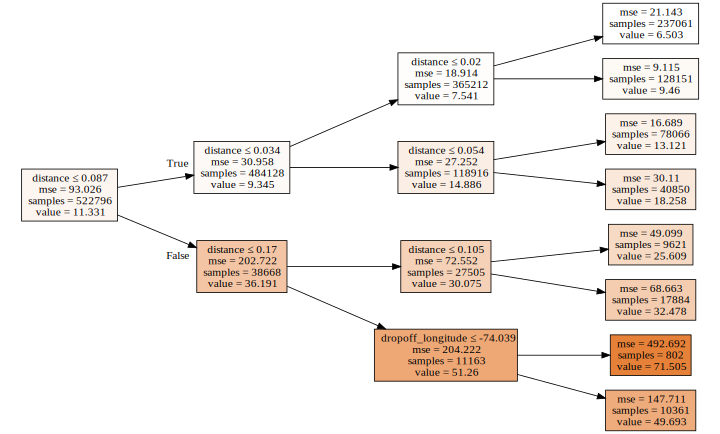

In [15]:
df_sub = raw_train.sample(40000)
X_sub = df_sub.drop(['key', 'pickup_datetime', 'fare_amount'], axis=1)
y_sub = df_sub.fare_amount

m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
draw_tree(m.estimators_[0], X_train, precision=3)

Most of our splits so far are on distance, telling us that from the data available, distance appears to be by some margin the most predictive of the features available. Engineering that feature appears to have been a good decision. While the RF would have made an insight along these lines by splitting on locations instead, having the distance feature available reduces the number of splits necessary.


## (b) Quick Random Forest Model: Bagged Tree

In [13]:
def split_vals(df, n): return df[:n].copy(), df[n:].copy()

n_valid = 9914  # same as Kaggle's test set size
n_trn = len(X_train)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(X_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((522796, 8), (522796,), (9914, 8), (9914,))

In [14]:
m = RandomForestRegressor()
m.fit(X_train, y_train)
m.score(X_train, y_train)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
print_score(m)

[1.8376414641663184, 4.492447830396936, 0.96369918651541, 0.7862530818762149]


While this simple, no-brainer Random Forest isn't doing a terrible job on our validation set, we could do better. The drop in $R^2$ from training to validation means that we are seriously overfitting our data. Also, if you think about it, an RMSE of \$4.31 on a taxi fare prediction is rather high!

To reiterate, we'd like to be able to beat our **baseline RF Regressor $R^2$ of 0.80**.